## Loading data

In [1]:
import os
import cv2
import numpy as np
import keras
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

import skimage.io as io
from skimage import measure
from skimage import morphology
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from sklearn.model_selection import train_test_split

import segmentation_models_pytorch as smp

import albumentations as albu
# from albumentations.pytorch import ToTensorV2

from loss_functions import DiceLoss, DiceBCELoss, IoULoss, BCELoss, FocalLoss, TverskyLoss, FocalTverskyLoss

In [2]:
DATA_DIR = '.\\'

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [3]:
images = [file for file in os.listdir(x_test_dir) if file.split('.')[-1]== 'tif']
images.sort()
len(images)

44

In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(30, 30))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title(), fontsize=20)
        plt.axis('off')
        plt.imshow(image, cmap='gray')
        plt.tight_layout()
    plt.tight_layout()
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [5]:
# custom sort function
import re

def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)


class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['background', 'void']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        sort_nicely(self.ids)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes) 

### Augmentations

In [6]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
# def get_training_augmentation():
#     train_transform = [

#         albu.OneOf(
#             [
#                 albu.HorizontalFlip(p=1),
#                 albu.VerticalFlip(p=1),
#                 albu.RandomRotate90(p=1)
#             ],
#             p=0.5,
#         ),

#         albu.ShiftScaleRotate(scale_limit=0.25, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0),
        
#         albu.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),  

#         albu.PadIfNeeded(min_height=1024, min_width=1024, always_apply=True, border_mode=0),
# #         albu.RandomCrop(height=1024, width=1024, always_apply=True),

#         albu.OneOf(
#             [
#                 albu.Sharpen(alpha=(0.0, 0.2), p=1),
#                 albu.CLAHE(p=1),
#                 albu.GaussianBlur(p=1),
#                 albu.GaussNoise(var_limit=(0.0, 20.0), p=1),
#             ],
#             p=0.5,
#         ),
        
#         albu.Lambda(mask=round_clip_0_1)
#     ]
#     return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
    albu.PadIfNeeded(1024, 1024)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

## Create model and train

In [7]:
ENCODER = 'se_resnext50_32x4d' # 'efficientnet-b3',   #'se_resnext50_32x4d',  'efficientnet-b5', 
ENCODER_WEIGHTS = 'imagenet'
BATCH_SIZE = 2
NUM_WORKERS = 0
CLASSES = ['void']
ACTIVATION = 'sigmoid' 
DEVICE = 'cuda'
PIN_MEMORY = True

model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
#     decoder_attention_type='scse',
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

### Visualize predictions of new test images

In [8]:
# load best saved checkpoint
best_model_unetplus_vgg19_dicebce = torch.load('./Unet++_vgg19_batch2_diceBCE_heavy-aug_200epoch_model_4.pth')
best_model_unetplus_vgg19_jaccard = torch.load('./Unet++_vgg19_batch2_jaccard_heavy-aug_300epoch_model_4.pth')
best_model_unetplus_seresnext50_dicebce = torch.load('./Unet++_batch2_diceBCE_heavy-aug_reflect_border_200epoch_model_4.pth')
best_model_unetplus_seresnext50_jaccard = torch.load('./Unet++_batch2_jaccard_heavy-aug_200epoch_model_4.pth')
best_model_unetplus_efficientnetb3_dicebce = torch.load('./Unet++_efficientnet-b3_batch3_diceBCE_heavy-aug_200epoch_model_4.pth')
best_model_unetplus_efficientnetb3_jaccard = torch.load('./Unet++_efficientnet-b3_batch3_jaccard_heavy-aug_300epoch_model_4.pth')
best_model_unetplus_seresnext50_jaccard_model5 = torch.load('./Unet++_se-resnext50_batch2_jaccard_heavy-aug_300epoch_model_5.pth')

best_model_unet_seresnext50_dicebce = torch.load('./Unet_se_resnext50_batch3_diceBCE_heavy-aug_300epoch_model_4.pth')
best_model_unet_seresnext50_jaccard = torch.load('./Unet_se_resnext50_batch3_jaccard_heavy-aug_300epoch_model_4.pth')     
best_model_unet_efficientnetb3_dicebce = torch.load('./Unet_efficientnet-b3_batch5_diceBCE_heavy-aug_300epoch_model_4.pth')
best_model_unet_efficientnetb3_jaccard = torch.load('./Unet_efficientnet-b3_batch5_jaccard_heavy-aug_300epoch_model_4.pth')
best_model_unet_seresnext50_jaccard_medium = torch.load('./Unet_se-resnext50_batch3_jaccard_medium-aug_300epoch_model_4.pth')
best_model_unet_seresnext50_dicebce_model5 = torch.load('./Unet_se-resnext50_batch3_diceBCE_heavy-aug_300epoch_model_5.pth') 

best_model_fpn_efficientnetb5_dicebce = torch.load('./FPN_efficientnet-b5_batch3_diceBCE_heavy-aug_300epoch_model_4.pth')
best_model_fpn_efficientnetb5_jaccard = torch.load('./FPN_efficientnet-b5_batch3_jaccard_heavy-aug_300epoch_model_4.pth')

# model_list
models = ['unetplus_vgg19_dicebce', 'unetplus_seresnext50_dicebce', 'unetplus_efficientnetb3_dicebce', 'unetplus_vgg19_jaccard', 
          'unetplus_seresnext50_jaccard', 'unetplus_efficientnetb3_jaccard', 'unetplus_seresnext50_jaccard_model5', 
          'unet_seresnext50_dicebce', 'unet_efficientnetb3_dicebce', 'unet_seresnext50_jaccard', 'unet_efficientnetb3_jaccard', 
          'unet_seresnext50_jaccard_medium', 'unet_seresnext50_dicebce_model5', 'fpn_efficientnetb5_dicebce', 'fpn_efficientnetb5_jaccard']

### Test set

In [14]:
# create directory of 2020 image dataset
x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')


# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

### Ensemble models

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

ids_test = os.listdir(x_test_dir)
sort_nicely(ids_test)

iou_scores= []
accuracies = []
precisions = []
recalls = []
f1_scores = []

# path for prediction
prediction_dir = os.path.join(DATA_DIR, 'test_prediction\\')

# for i in range(3):
for i in range(len(test_dataset)):
    image_vis = test_dataset_vis[i][0].astype('uint8')
    image, gt_mask = test_dataset[i]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    
    pr_masks = []
#     model_scores = []
    for model in models:
        best_model = eval('best_model_' + model)
        pr_mask = best_model.predict(x_tensor)

    #     pr_mask = (pr_mask.squeeze().cpu().numpy().round()) # round to nearest integer [0,1]
        pr_mask = (pr_mask.squeeze().cpu().numpy())

        mask_pred = pr_mask >= 0.5
        pr_masks.append(pr_mask)
    
    pr_masks = np.array(pr_masks)
    # Ensemble-1 by averaging probability: soft
    pr_mask_ensemble1 = np.mean(pr_masks, axis=0)
    
    # Ensemble-2 by maximum vote: hard
#     pr_mask_ensemble1 = np.mean(pr_masks>0.5, axis=0)
    
    mask_pred = pr_mask_ensemble1 >= 0.5
    mask_pred = mask_pred.astype('uint8')
    
    # save mask_prediction
    # save predicted masks as seperate files
    img_name = test_dataset.ids[i].split('.ti')[0]
    img_name = img_name + '.tif' 
    io.imsave(prediction_dir + img_name, mask_pred)
    
    iou_score = np.sum(gt_mask * mask_pred) / (np.sum(gt_mask + mask_pred) - np.sum(gt_mask * mask_pred))
    accuracy = np.sum(gt_mask == mask_pred) / (gt_mask.shape[0] * gt_mask.shape[1]) # accuracy
    precision = np.sum(gt_mask * mask_pred) / np.sum(mask_pred)  # precision
    recall = np.sum(gt_mask * mask_pred) / np.sum(gt_mask)  # recall
    f1_score = 2*np.sum(gt_mask * mask_pred) / (np.sum(mask_pred) + np.sum(gt_mask))  # f1
    
    iou_scores.append(iou_score)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

    print(f"{ids_test[i]}: IoU_score - {iou_score:.4f}, f1_score - {f1_score:.4f}")
#     print(f"{iou_score:.4f}, {accuracy:.4f}, {precision:.4f}, {recall:.4f}, {f1_score:.4f}")
#     print(f"{iou_score:.4f}")
    
    id = ids_test[i]
        
    # plot mask as overlay
    img = image_vis
    mask = mask_pred
    mask = mask==1
    # mask = binary_closing(mask)
    # mask = binary_erosion(mask, square(2))
    mask = morphology.remove_small_objects(mask, 50)
    mask = morphology.remove_small_holes(mask, 50)
#     mask = morphology.binary_erosion(mask, square(1))
    contours = measure.find_contours(mask, 0)

    # Display the image and plot all contours found
    fig, ax = plt.subplots(1, 2, figsize=(20, 20))
    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].set_title(id, fontsize=15)
    for contour in contours:
        ax[0].plot(contour[:, 1], contour[:, 0], linewidth=1, alpha=0.5, color='red')
    ax[0].axis('off')
    ax[0].axes.xaxis.set_visible(False)
    ax[0].axes.yaxis.set_visible(False)
    
    ax[1].imshow(gt_mask, cmap=plt.cm.gray)
    ax[1].set_title('Ground truth vs Prediction', fontsize=15)
    for contour in contours:
        ax[1].plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
    ax[1].axis('off')
    ax[1].axes.xaxis.set_visible(False)
    ax[1].axes.yaxis.set_visible(False)
    plt.tight_layout()
    plt.show()
    
iou_score = np.mean(np.array(iou_scores))
accuracy = np.mean(np.array(accuracies))
precision = np.mean(np.array(precisions))
recall = np.mean(np.array(recalls))
f1_score = np.mean(np.array(f1_scores))

print(f'mean iou score: {iou_score:.4f}, accuracy: {accuracy:.4f}, precision: {precision:.4f}, recall: {recall:.4f}, f1_score: {f1_score:.4f}')

### save prediction as mask

In [ ]:
import time
from skimage import io 
from skimage import img_as_ubyte, img_as_float
from tqdm import tqdm

start = time.time()

# image number
num_image = len(test_dataset)

#
for i in tqdm(range(num_image)):   
    image_vis = test_dataset_vis[i][0].astype('uint8')
    image, gt_mask = test_dataset[i]
    
    # gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    pr_mask = img_as_ubyte(pr_mask)

    # save predicted masks as seperate files
    img_name = test_dataset.ids[i].split('.ti')[0]
    img_name = img_name + '.tif' 
    io.imsave(prediction_dir + img_name, pr_mask)


end = time.time()
print(f'\n Processing time for one image is {(end - start)/num_image:.2f} second')

### Test for new images

In [11]:
# create directory of 2020 image dataset
x_test_dir = os.path.join(DATA_DIR, 'new_image_Sep_2022')
y_test_dir = os.path.join(DATA_DIR, 'new_image_Sep_2022')


# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

### Ensemble model

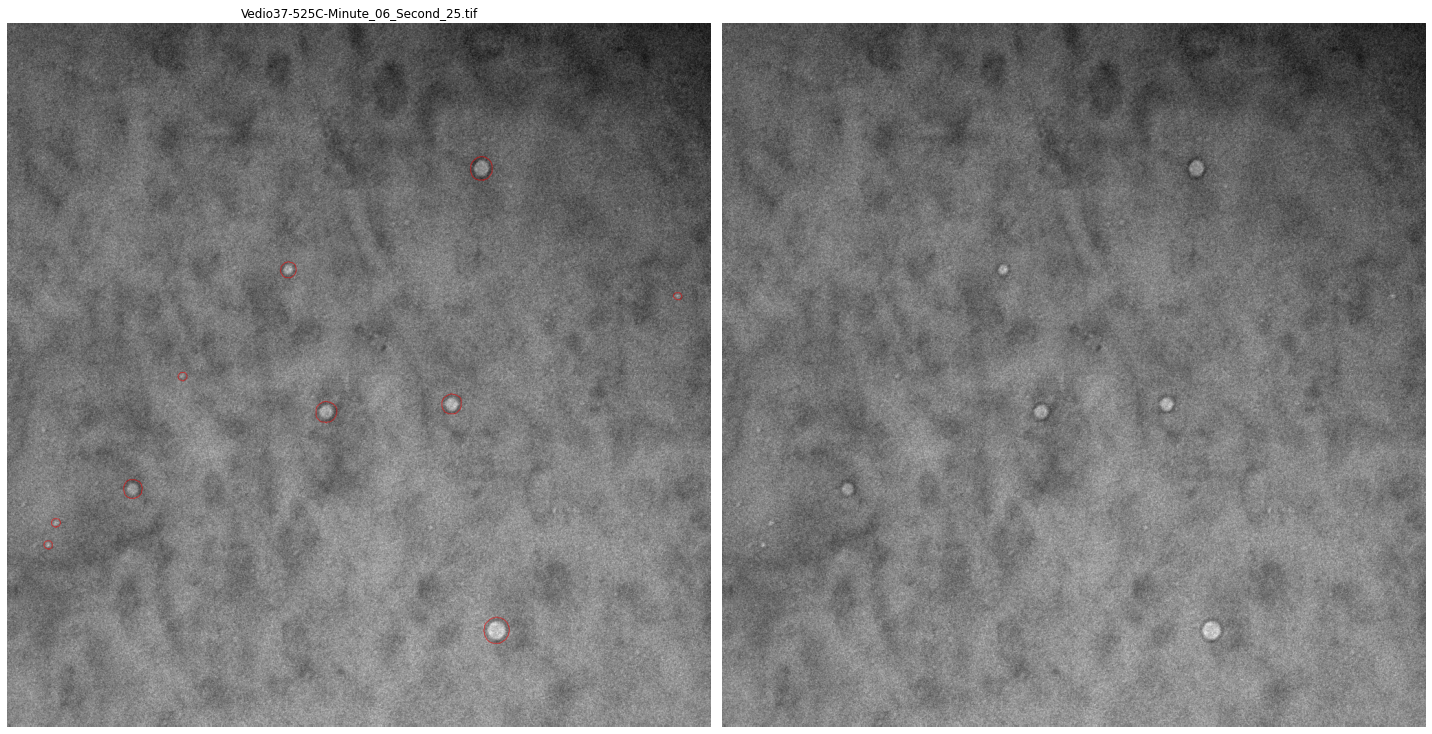

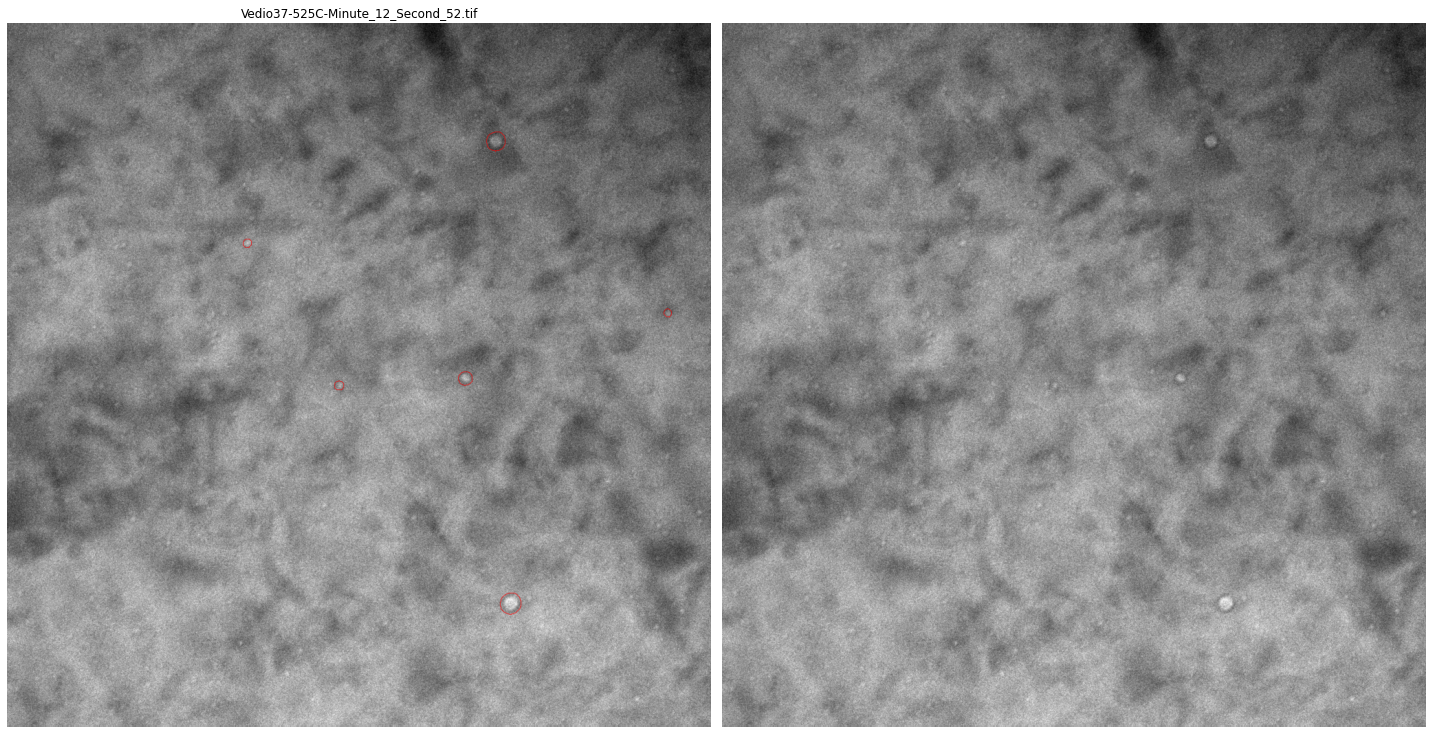

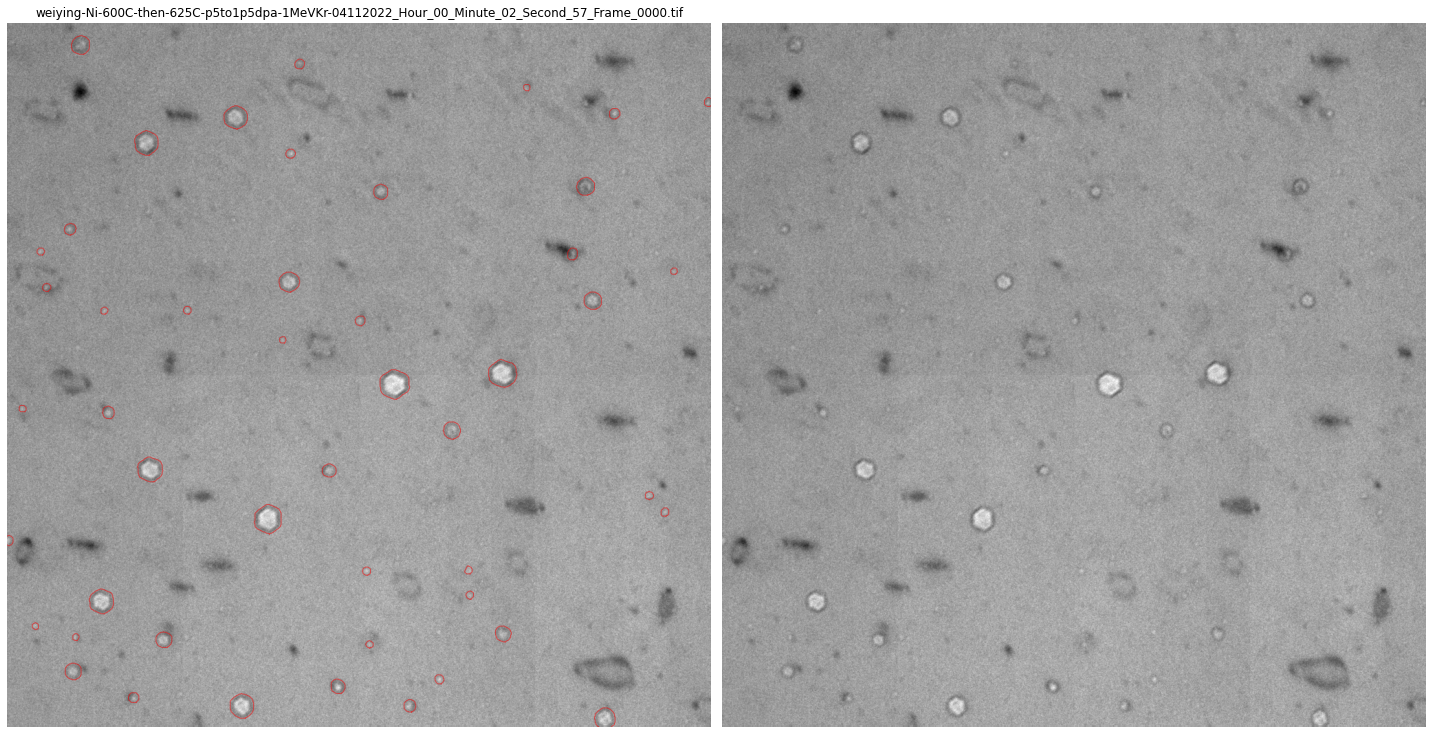

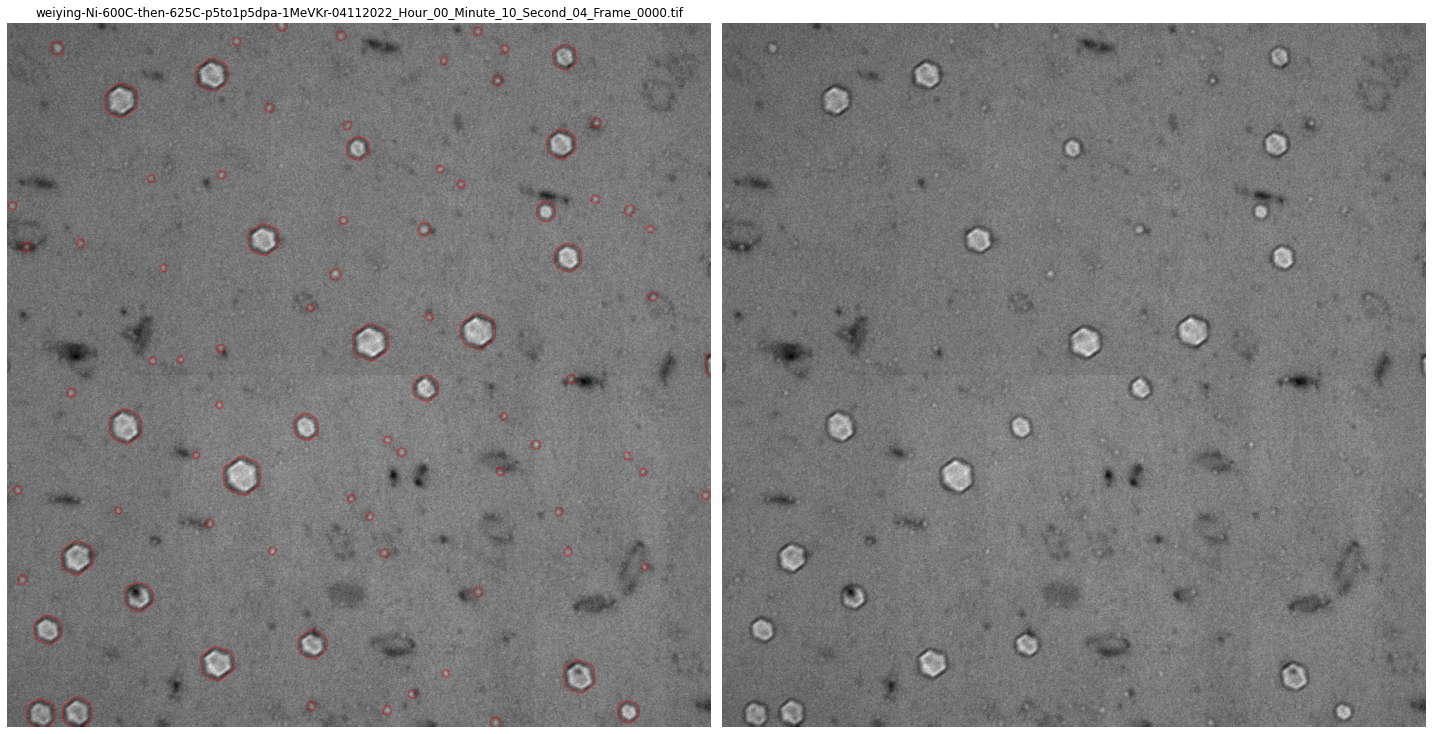

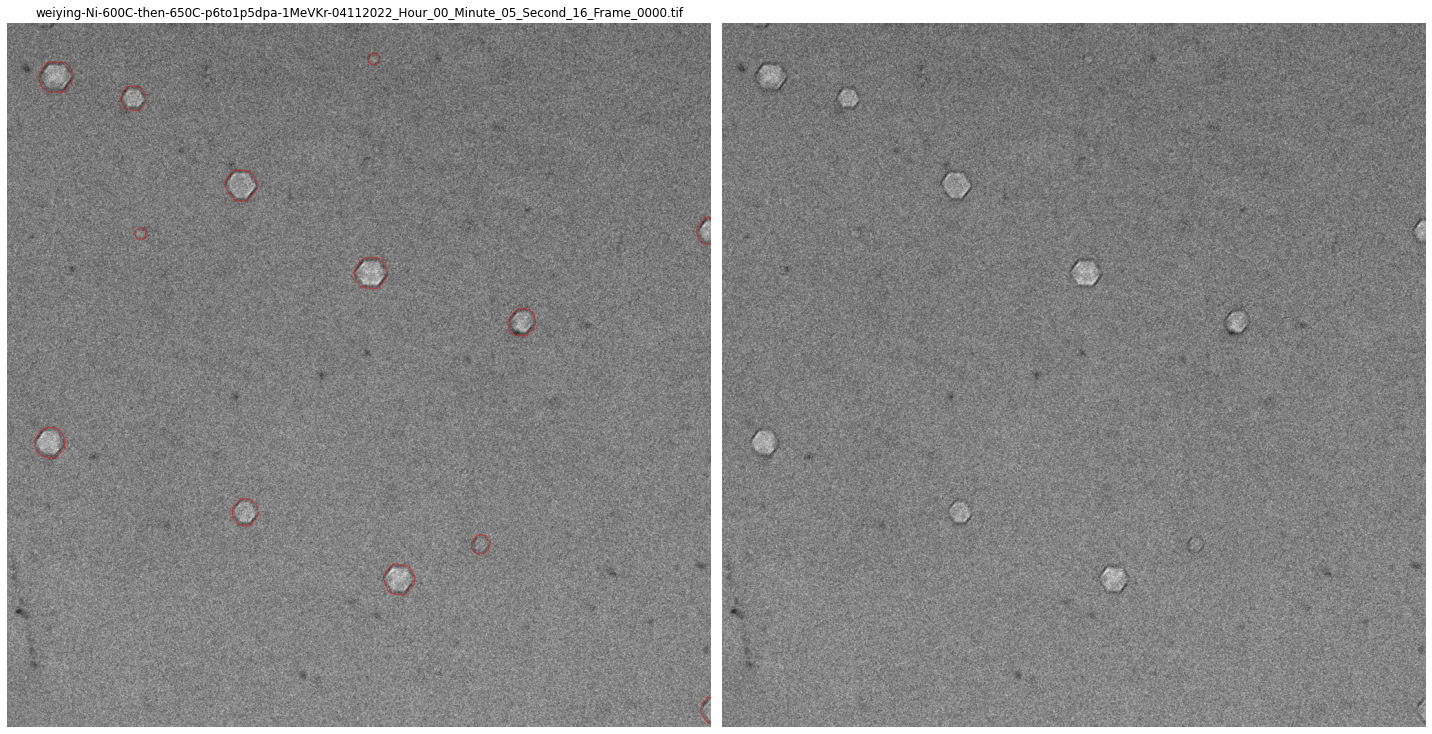

In [12]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

ids_test = os.listdir(x_test_dir)
sort_nicely(ids_test)


for i in range(len(test_dataset)):
    image_vis = test_dataset_vis[i][0].astype('uint8')
    image, gt_mask = test_dataset[i]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    
    pr_masks = []
#     model_scores = []
    for model in models:
        best_model = eval('best_model_' + model)
        pr_mask = best_model.predict(x_tensor)

    #     pr_mask = (pr_mask.squeeze().cpu().numpy().round()) # round to nearest integer [0,1]
        pr_mask = (pr_mask.squeeze().cpu().numpy())

        mask_pred = pr_mask >= 0.5
        pr_masks.append(pr_mask)
    
    pr_masks = np.array(pr_masks)
    # Ensemble-1 by averaging probability: soft
    pr_mask_ensemble1 = np.mean(pr_masks, axis=0)
    
    # Ensemble-2 by maximum vote: hard
#     pr_mask_ensemble1 = np.mean(pr_masks>0.5, axis=0)
    
    mask_pred = pr_mask_ensemble1 >= 0.5
    mask_pred = mask_pred.astype('uint8')
    
    id = ids_test[i]
        
    # plot mask as overlay
    img = image_vis
    mask = mask_pred
    mask = mask==1
    # mask = binary_closing(mask)
    # mask = binary_erosion(mask, square(2))
    mask = morphology.remove_small_objects(mask, 50)
    mask = morphology.remove_small_holes(mask, 50)
#     mask = morphology.binary_erosion(mask, square(1))
    contours = measure.find_contours(mask, 0)

    # Display the image and plot all contours found
    fig, ax = plt.subplots(1, 2, figsize=(20, 20))
    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].set_title(id, fontsize=12)
    for contour in contours:
        ax[0].plot(contour[:, 1], contour[:, 0], linewidth=1, alpha=0.5, color='red')
    ax[0].axis('off')
    ax[0].axes.xaxis.set_visible(False)
    ax[0].axes.yaxis.set_visible(False)
    
    ax[1].imshow(img, cmap=plt.cm.gray)
#     ax[1].set_title('Ground truth vs Prediction', fontsize=15)
#     for contour in contours:
#         ax[1].plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
    ax[1].axis('off')
    ax[1].axes.xaxis.set_visible(False)
    ax[1].axes.yaxis.set_visible(False)
    plt.tight_layout()
    plt.show()
    